In [32]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.nodes import Reservoir
from sklearn.linear_model import Ridge as RidgeReg
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
import reservoirpy as rpy

In [33]:
# ─── Reproducibility ─────────────────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
rpy.verbosity(0)
rpy.set_seed(SEED)

# ─── 1) Load & shuffle dataset ───────────────────────────────────────────────
data = np.load('threebody_dataset2.npz')
X_all    = data['X']            # (N_runs, TIMESTEPS, 6)
masses   = data['masses']      # (N_runs, 3)
init_pos = data['init_pos']  # (N_runs, 3, 2)
init_vel = data['init_vel']  # (N_runs, 3, 2)

X_all, masses, init_pos, init_vel = shuffle(
    X_all, masses, init_pos, init_vel,
    random_state=SEED
)


In [34]:
# ─── 2) Conditioning function ─────────────────────────────────────────────────
def prepare_conditioning(idx):
    pos = init_pos[idx].copy()
    vel = init_vel[idx].copy()
    m   = masses[idx]
    M   = m.sum()
    xcm = (pos[:,0] * m).sum() / M
    ycm = (pos[:,1] * m).sum() / M
    vxcm = (vel[:,0] * m).sum() / M
    vycm = (vel[:,1] * m).sum() / M
    pos[:,0] -= xcm; pos[:,1] -= ycm
    vel[:,0] -= vxcm; vel[:,1] -= vycm
    return np.hstack([m, pos.flatten(), vel.flatten()])  # (15,)

TIMESTEPS = X_all.shape[1]

def build_inputs(idx):
    traj     = X_all[idx]                   # (TIMESTEPS, 6)
    cond_vec = prepare_conditioning(idx)    # (15,)
    cond_rep = np.repeat(cond_vec[None,:], TIMESTEPS, axis=0)  # (TIMESTEPS, 15)
    return np.hstack([traj, cond_rep])     # (TIMESTEPS, 21)

In [35]:
# ─── 3) Training split & parameters ──────────────────────────────────────────
N = len(X_all)
TRAIN_END = int(0.7 * N)         # 70% for training
VAL_END   = int(0.85 * N)        # next 15% for validation
# last 15% for test

train_idx = list(range(0, TRAIN_END))
val_idx   = list(range(TRAIN_END, VAL_END))
test_idx  = list(range(VAL_END, N))

WASHOUT        = 100
REGULARIZATION = 1e-6
RC_CONNECTIVITY  = 0.1
IN_CONNECTIVITY  = 0.2

# Build train inputs/targets
inputs_train  = np.vstack([build_inputs(i)[:-1] for i in train_idx])
targets_train = np.vstack([X_all[i,1:,:]       for i in train_idx])

# Build val inputs/targets
inputs_val    = np.vstack([build_inputs(i)[:-1] for i in val_idx])
targets_val   = np.vstack([X_all[i,1:,:]       for i in val_idx])

# Build test inputs/targets
inputs_test   = np.vstack([build_inputs(i)[:-1] for i in test_idx])
targets_test  = np.vstack([X_all[i,1:,:]       for i in test_idx])

In [36]:
# ─── 4) Scale inputs & targets ──────────────────────────────────────────────
in_scaler  = StandardScaler().fit(inputs_train)
tg_scaler  = StandardScaler().fit(targets_train)

inputs_train_scaled = in_scaler.transform(inputs_train)
targets_train_scaled= tg_scaler.transform(targets_train)

inputs_val_scaled   = in_scaler.transform(inputs_val)
targets_val_scaled  = tg_scaler.transform(targets_val)

inputs_test_scaled  = in_scaler.transform(inputs_test)
targets_test_scaled = tg_scaler.transform(targets_test)


In [40]:
# ─── 5) Hyperparameter grid & validation‐based selection ────────────────────
grid = {
    'units':         [500],
    'sr':            [0.5],
    'input_scaling': [0.05],
    'sparsity':      [0.01]
}

best_val_mse    = np.inf
best_train_mse  = None
best_params     = None
best_res        = None
best_readout    = None

total_runs = (len(grid['units'])
            * len(grid['sr'])
            * len(grid['input_scaling'])
            * len(grid['sparsity']))
run_count = 0

for units in grid['units']:
    for sr in grid['sr']:
        for inp_scale in grid['input_scaling']:
            for sparsity in grid['sparsity']:
                run_count += 1
                print(f"Run {run_count}/{total_runs} | "
                      f"units={units}, sr={sr}, "
                      f"input_scaling={inp_scale}, sparsity={sparsity}")

                # 1) Train on TRAIN split
                res = Reservoir(
                    units=units, sr=sr,
                    input_scaling=inp_scale,
                    rc_connectivity=sparsity,
                    input_connectivity=IN_CONNECTIVITY,
                    seed=SEED
                )
                states_tr_full = res.run(inputs_train_scaled, reset=True)
                states_tr      = states_tr_full[WASHOUT:]
                targs_tr       = targets_train_scaled[WASHOUT:]

                # 2) Fit readout
                readout = RidgeReg(alpha=REGULARIZATION)
                readout.fit(states_tr, targs_tr)

                # 3) Train‐MSE (diagnostic)
                preds_tr = readout.predict(states_tr)
                train_mse = mean_squared_error(targs_tr, preds_tr)
                print(f"   → Train MSE: {train_mse:.6f}")

                # 4) Evaluate on VAL split
                states_val_full = res.run(inputs_val_scaled, reset=True)
                states_val      = states_val_full[WASHOUT:]
                targs_val       = targets_val_scaled[WASHOUT:]
                preds_val       = readout.predict(states_val)
                val_mse         = mean_squared_error(targs_val, preds_val)
                print(f"   →  Val MSE: {val_mse:.6f}\n")

                # 5) Select by VAL MSE
                if val_mse < best_val_mse:
                    best_val_mse   = val_mse
                    best_train_mse = train_mse
                    best_params    = {
                        'units':units,
                        'sr':sr,
                        'input_scaling':inp_scale,
                        'sparsity':sparsity
                    }
                    best_res       = res
                    best_readout   = readout

print(f"\nBest params (by VAL): {best_params}")
print(f"   Train MSE @ best: {best_train_mse:.6f}")
print(f"    Val  MSE @ best: {best_val_mse:.6f}")


Run 1/1 | units=500, sr=0.5, input_scaling=0.05, sparsity=0.01
   → Train MSE: 0.000000
   →  Val MSE: 0.036498


Best params (by VAL): {'units': 500, 'sr': 0.5, 'input_scaling': 0.05, 'sparsity': 0.01}
   Train MSE @ best: 0.000000
    Val  MSE @ best: 0.036498


In [41]:
# ─── 6) Validation on VAL set ───────────────────────────────────────────────
states_val      = best_res.run(inputs_val_scaled, reset=True)[WASHOUT:]
preds_val_s     = best_readout.predict(states_val)
preds_val       = tg_scaler.inverse_transform(preds_val_s)
true_val        = targets_val[WASHOUT:]
mse_val = mean_squared_error(true_val, preds_val)
mae_val = mean_absolute_error(true_val, preds_val)
print(f"Validation MSE: {mse_val:.5f}, MAE: {mae_val:.5f}")

# ─── ) FINAL TEST on TEST set ──────────────────────────────────────────────
states_test     = best_res.run(inputs_test_scaled, reset=True)[WASHOUT:]
preds_test_s    = best_readout.predict(states_test)
preds_test      = tg_scaler.inverse_transform(preds_test_s)
true_test       = targets_test[WASHOUT:]
mse_test = mean_squared_error(true_test, preds_test)
mae_test = mean_absolute_error(true_test, preds_test)
print(f"Test      MSE: {mse_test:.5f}, MAE: {mae_test:.5f}")

Validation MSE: 349746.65438, MAE: 34.30873
Test      MSE: 201.93909, MAE: 2.01779


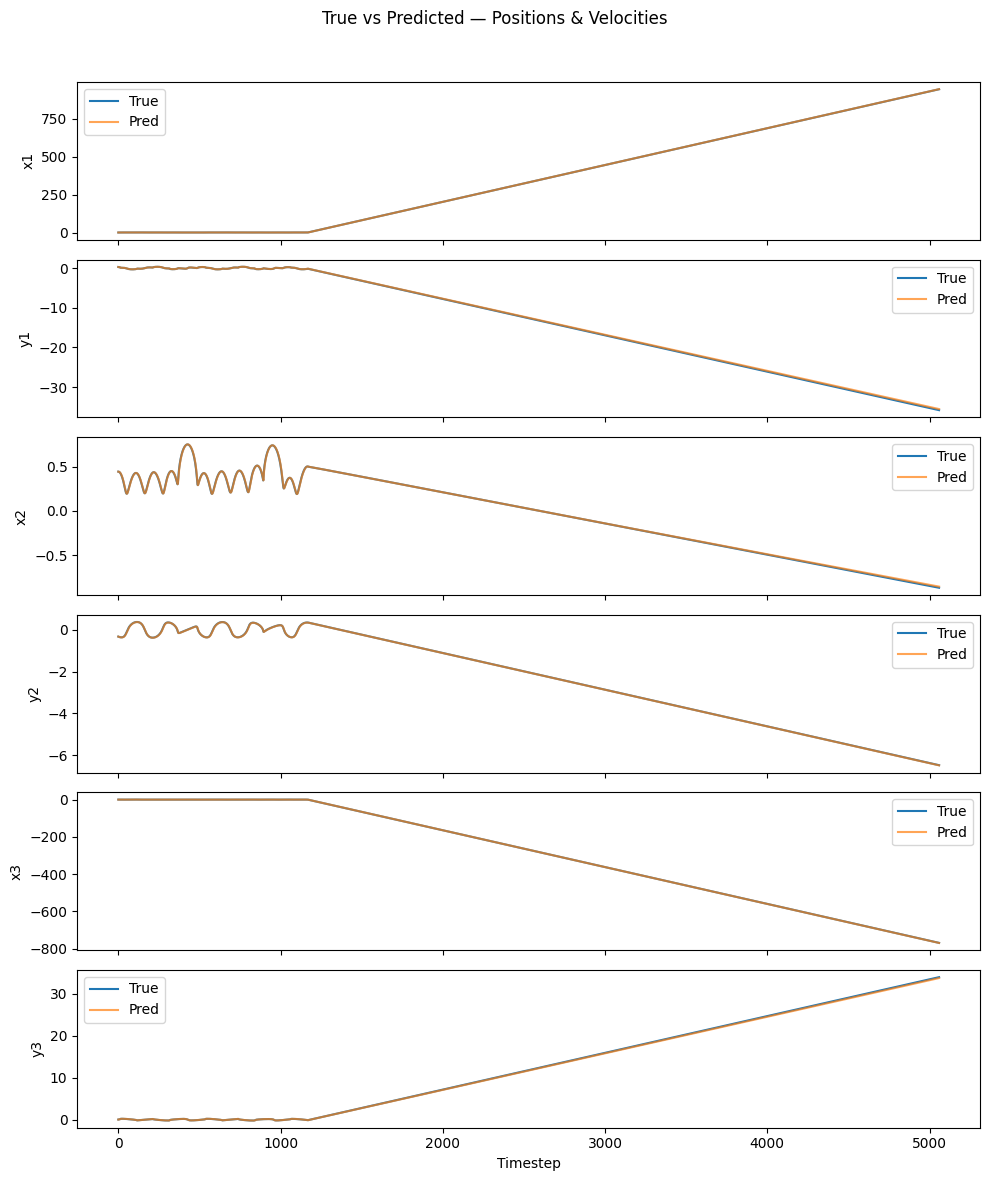

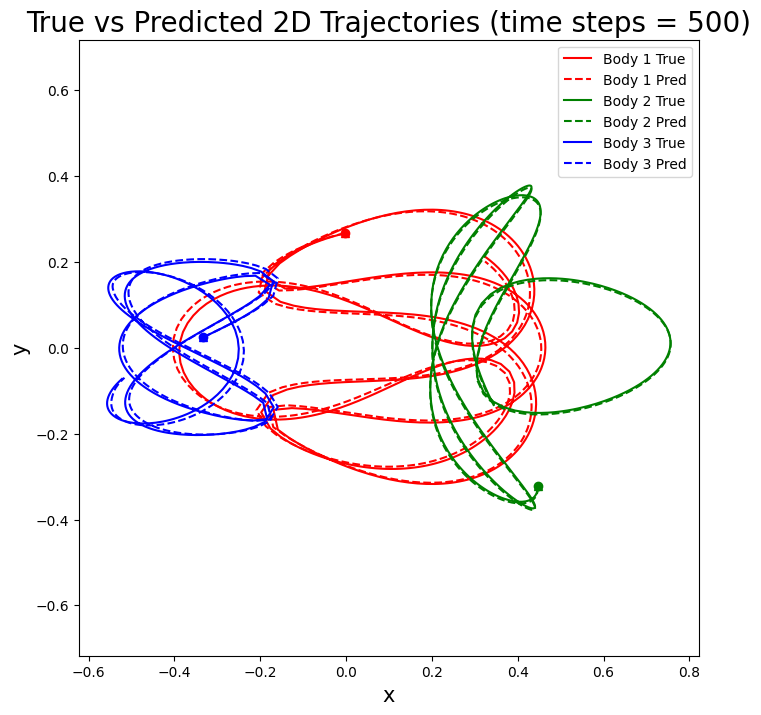

In [50]:
# ─── 7) Prepare one validation run for ESN plotting ─────────────────────────
import random

# pick a single run from your validation indices
val_run = random.choice(val_idx)

# build inputs (drop last step), scale, run ESN
val_input        = build_inputs(val_run)[:-1]                  # (TIMESTEPS-1, 21)
val_scaled       = in_scaler.transform(val_input)             # scale inputs
states_full      = best_res.run(val_scaled, reset=True)       # run ESN
states           = states_full[WASHOUT:]                      # discard washout
val_preds_s      = best_readout.predict(states)               # scaled preds
val_preds        = tg_scaler.inverse_transform(val_preds_s)   # un-scale

# true targets for that run
val_targets_full = X_all[val_run, 1:, :]                      # (TIMESTEPS-1, 6)
val_targets      = val_targets_full[WASHOUT:]                 # discard washout

# align at t=0 so curves overlay
shift = val_targets[0] - val_preds[0]
val_preds += shift

# ─── 8) Plot validation results ──────────────────────────────────────────────
# (a) Positions & velocities over time
fig, axs = plt.subplots(6,1,figsize=(10,12), sharex=True)
coords = ['x1','y1','x2','y2','x3','y3']
for i, ax in enumerate(axs):
    ax.plot(val_targets[:, i], label='True')
    ax.plot(val_preds[:,   i], label='Pred', alpha=0.7)
    ax.set_ylabel(coords[i])
    ax.legend()
axs[-1].set_xlabel('Timestep')
plt.suptitle('True vs Predicted — Positions & Velocities')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# (b) 2D trajectories for first 500 steps
n_plot = 500
tt = val_targets[:n_plot]
pp = val_preds[:n_plot]
fig, ax = plt.subplots(figsize=(8,8))
colors = ['r','g','b']
for i, c in enumerate(colors):
    ax.plot(tt[:,2*i],   tt[:,2*i+1],   '-',  label=f'Body {i+1} True',  color=c)
    ax.plot(pp[:,2*i],   pp[:,2*i+1],   '--', label=f'Body {i+1} Pred',  color=c)
    ax.plot(tt[0,2*i],   tt[0,2*i+1],   'o',  color=c)
    ax.plot(pp[0,2*i],   pp[0,2*i+1],   '^',  color=c)
# increase title font size
ax.set_title(f'True vs Predicted 2D Trajectories (time steps = {n_plot})', fontsize=20)
ax.set_xlabel('x', fontsize=15); ax.set_ylabel('y', fontsize=15)
ax.axis('equal'); ax.legend()
plt.show()



In [43]:
import pandas as pd

# ─── Compute MAE per timestep ──────────────────────────────────────────────
# val_preds and val_targets are both (T, 6)
abs_errors    = np.abs(val_preds - val_targets)         # absolute error at each timestep & dim
mae_per_step  = abs_errors.mean(axis=1)                 # mean across the 6 outputs → shape (T,)
cumulative_mae = np.cumsum(mae_per_step)               # running sum of MAE

# ─── Build DataFrame & write to CSV ───────────────────────────────────────
df_error = pd.DataFrame({
    'timestep':        np.arange(len(mae_per_step)),
    'mae':             mae_per_step,
    'cumulative_mae':  cumulative_mae
})

csv_path = 'cumulative_prediction_error_ESN.csv'
df_error.to_csv(csv_path, index=False)
print(f"Cumulative MAE data saved to {csv_path}")


Cumulative MAE data saved to cumulative_prediction_error_ESN.csv
